In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from game import Game
from player import Player
import pprint as pp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from hybiak import Hybiak
from simpleplayer import SimplePlayer
from golab_uladzislau import GolabUladzislau

In [4]:
### Generate cards from 9 to 14 (ace) for all colors/symbols (0, 1, 2, 3)
def getDeck():
    return [(number, color) for color in range(4) for number in range(9, 15)]
    
pp.pprint(getDeck())

[(9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (9, 3),
 (10, 3),
 (11, 3),
 (12, 3),
 (13, 3),
 (14, 3)]


In [5]:
### Shuffle the cards randomly. Each player gets 9 cards
### (so one player cannot be certain which cards the other player has)

def getShuffled(deck):
    D = set(deck)
    A = set(random.sample(deck, 8))
    B = set(random.sample(list(D - A), 8))
    C = D - A - B
    if len(A.intersection(B)) > 0: print("Shuffle error 1")
    if len(A.intersection(B)) > 0: print("Shuffle error 2")
    if len(A.intersection(C)) > 0: print("Shuffle error 3") 
    DS = A | B | C
    if not DS == D: print("Shuffle error 4")  
    return list(A), list(B), list(C)

p1, p2, notUsed, = getShuffled(getDeck())
print(p1)
print(p2)


[(11, 0), (14, 1), (12, 0), (11, 3), (13, 3), (11, 2), (14, 2), (9, 1)]
[(11, 1), (9, 0), (13, 1), (10, 1), (12, 3), (14, 0), (10, 0), (13, 2)]


In [6]:
# Some examplary random player

class RandomPlayer(Player):
    
    ### player's random strategy
    def putCard(self, declared_card):
        
        ### check if must draw
        if len(self.cards) == 1 and declared_card is not None and self.cards[0][0] < declared_card[0]:
            return "draw"
        
        ### player randomly decides which card put on the table
        card = random.choice(self.cards)
        declaration = card
        
        ### player randomly decides whether to cheat or not
        cheat = np.random.choice([True, False])
       
        ### if (s)he decides to cheat, (s)he randomly declares the card.
        if cheat:
            declaration = random.choice(self.cards)             
            
        ### Yet, declared card should be no worse than a card on the top of the pile . 
        if declared_card is not None and declaration[0] < declared_card[0]:
            declaration = (min(declared_card[0]+1,14), declaration[1])

        ### return the decision (true card) and declaration (player's declaration)
        return card, declaration
    
    ### randomly decides whether to check or not
    def checkCard(self, opponent_declaration):
        return np.random.choice([True, False])
    

Analyze few moves...

In [11]:
### Perform a full game 100 times
STAT_NAMES = ["Wins", "Draws", "Moves", "Cards", "Pile Size", "Checks", "Draw Decisions", "Cheats", "Errors", "Total errors"]
ANALYZE_STATS = [0, 1, 2, 3, 5, 6, 7, 8]

def printResults(results):
    print("Wins:")
    print(results[0])
    print("Draws:")
    print(results[1])
    print("Moves:")
    print(stats_moves[2])
    print("Cards:")
    print(results[3])
    print("Pile size:")
    print(results[4])
    print("Checks:")
    print(results[5])
    print("Draw decisions:")
    print(results[6])
    print("Cheats:")
    print(results[7])
    print("Errors:")
    print(results[8])
    print("Total errors:")
    print(results[9])

def comparePlayers(player1_class, player2_class, p1_params, p2_params):
    stats_wins = [0, 0]
    stats_draws = [0, 0]
    stats_moves = [0, 0]
    stats_cards = [0, 0]
    stats_pile_size = 0
    stats_checks = [0, 0]
    stats_draw_decisions = [0, 0]
    stats_cheats = [0, 0]
    stats_errors = [0, 0]
    
    repeats = 10000
    errors = 0
    draws = 0

    for t in range(repeats):
        player1 = player1_class(**p1_params)
        player2 = player2_class(**p2_params)
        game = Game([player1, player2], log = False)
    
        error = False
        draw = False
        
        while True:
            valid, player = game.takeTurn(log = False)
            if game.moves[0] > 100 or game.moves[1] > 100:
                draws += 1
                stats_draws[0] += 1
                stats_draws[1] += 1
                if (game.player_cards[0] < game.player_cards[1]):
                    stats_wins[0] += 1
                if (game.player_cards[0] > game.player_cards[1]):
                    stats_wins[1] += 1
                    
                    
                draw=True
                print("DRAW")
                break
            if not valid:
                error = True
                stats_errors[player] += 1
                errors += 1
                break
            if game.isFinished(log = False):
                stats_wins[player] += 1
                break
            
        stats_pile_size += len(game.pile)
        if error: continue
        #if draw: continue
       
        for j in range(2):
            stats_moves[j] += game.moves[j]
            stats_cheats[j] += game.cheats[j]
            stats_checks[j] += game.checks[j]
            stats_draw_decisions[j] += game.draw_decisions[j]
            stats_cards[j] += len(game.player_cards[j])

    div = repeats - errors
    if div > 0:
            
        stats_pile_size /= div          
        for j in range(2):
            stats_moves[j] /= div
            stats_cheats[j] /= div
            stats_checks[j] /= div
            stats_draw_decisions[j] /= div
            stats_cards[j] /= div
            
    return [stats_wins, stats_draws, stats_moves, stats_cards, stats_pile_size, stats_checks, 
            stats_draw_decisions, stats_cheats, stats_errors, errors, draws]  


In [9]:
initial_params = {
    'p85': 0.85,
    'p80': 0.80,
    'p75': 0.75,
    'p70': 0.70,
    'p60': 0.60,
    'p50': 0.50,
    'name': 'HYBIAK'
}

In [12]:
simple = SimplePlayer
golab = GolabUladzislau
player = Hybiak    
result1 = comparePlayers(player, simple, initial_params, {'name':'SIMPLE'})
result1[0][0]

7141

In [17]:
simple_scores = []
player = Hybiak
probas = np.linspace(0.1,0.9,9)

for proba in probas:
    p = {"p": proba, 'name':''}
    result = comparePlayers(player, SimplePlayer, initial_params, p)
    simple_scores.append(result[0][0])

6438 6807 7241 7678 8327 9037 9551 9877 9987


Text(0, 0.5, 'Win %')

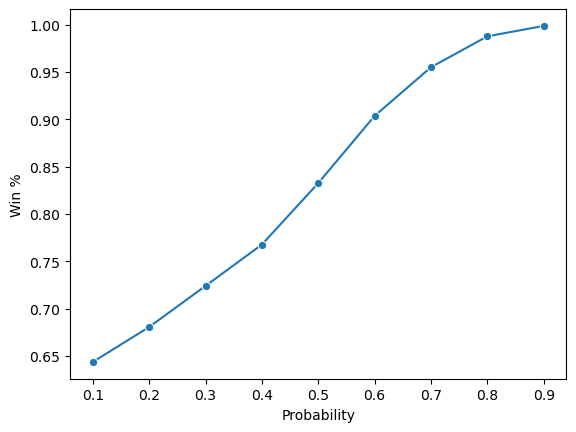

In [18]:
import seaborn as sns
print(*simple_scores)
sns.lineplot(x=probas,y=np.array(simple_scores)/10e3, marker='o')
plt.xlabel('Probability')
plt.ylabel('Win %')

In [ ]:
# 6622 7014 7408 7860 8549 9037 9621 9885 9984

In [23]:
p = {'name':''}
result = comparePlayers(player, golab, initial_params, p)
golab_result = result[0][0]

In [25]:
maxes = simple_scores[:3] + [golab_result]
maxes

[6438, 6807, 7241, 6375]

In [26]:
probas = probas[:3]

In [27]:
weights = [1.25, 1.1, 1, 1.35]

In [28]:
probas

array([0.1, 0.2, 0.3])

# COMPARE

In [40]:
probas

array([0.1, 0.2, 0.3])

In [42]:
[x / y for x,y in zip(weights, maxes)]

[0.0001941596769182976,
 0.00016159835463493464,
 0.00013810247203424942,
 0.00021176470588235295]

In [ ]:
import optuna

epsilon = 0.2
initial_params = {
    'p85': 0.85,
    'p80': 0.80,
    'p75': 0.75,
    'p70': 0.70,
    'p60': 0.60,
    'p50': 0.50
}


def weighted_result(results, weights, maxes):
    norm_results = [r / m for r, m in zip(results, maxes)]
    weighted_score = sum([w * n for w, n in zip(weights, norm_results)]) / sum(weights)
    return weighted_score


def objective(trial):
    p85 = trial.suggest_float('p85', max(0, initial_params['p85'] - epsilon), min(1, initial_params['p85'] + epsilon))
    p80 = trial.suggest_float('p80', max(0, initial_params['p80'] - epsilon), min(1, initial_params['p80'] + epsilon))
    p75 = trial.suggest_float('p75', max(0, initial_params['p75'] - epsilon), min(1, initial_params['p75'] + epsilon))
    p70 = trial.suggest_float('p70', max(0, initial_params['p70'] - epsilon), min(1, initial_params['p70'] + epsilon))
    p60 = trial.suggest_float('p60', max(0, initial_params['p60'] - epsilon), min(1, initial_params['p60'] + epsilon))
    p50 = trial.suggest_float('p50', max(0, initial_params['p50'] - epsilon), min(1, initial_params['p50'] + epsilon))
    
    simple = SimplePlayer
    golab = GolabUladzislau
    player = Hybiak

    params = {'name': '',
            'p85': p85,
            'p80': p80,
            'p75': p75,
            'p70': p70,
            'p60': p60,
            'p50': p50}
    
    results = []
    for proba in probas:
        p = {"p": proba, 'name':''}
        result = comparePlayers(player, SimplePlayer, params, p)
        results.append(result[0][0])
                         
    result_golab = comparePlayers(player, golab, params, {'name':''})
    results.append(result_golab[0][0])
    score = weighted_result(results, weights, maxes)
                         
    return score # funkcja celu to liczba ważona liczba zwycięstw na 10k rund

study = optuna.create_study(direction='maximize')
study.enqueue_trial(initial_params)

study.optimize(objective, n_trials=100) # ~10min -> dla 2 walk x 100 trialsów

best_params = study.best_params
best_score = study.best_value

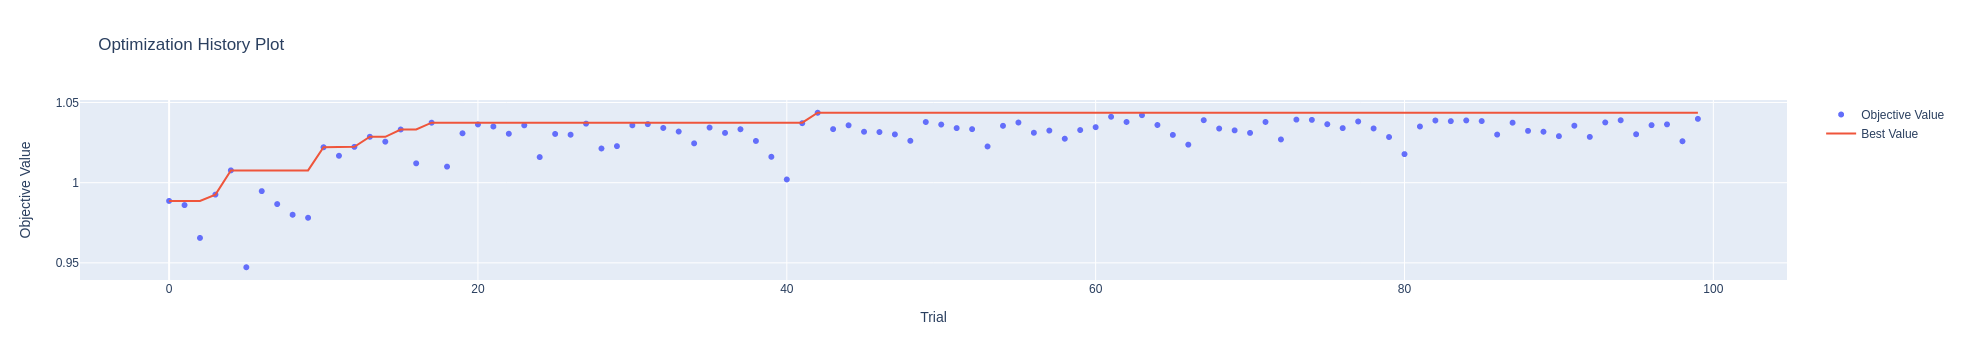

In [52]:
optuna.visualization.plot_optimization_history(study)

In [53]:
best_params['name']=''
initial_params['name']=''

In [54]:
def check_for_params(params):
    results = []
    for proba in probas:
        p = {"p": proba, 'name':''}
        result = comparePlayers(player, SimplePlayer, best_params, p)
        results.append(result[0][0])

    result_golab = comparePlayers(player, golab, best_params, {'name':''})
    results.append(result_golab[0][0])
    print(results)

In [56]:
check_for_params(initial_params)
check_for_params(best_params)

[6815, 7178, 7709, 6383]
[6702, 7309, 7682, 6334]


In [57]:
best_params

{'p85': 0.8151656065731939,
 'p80': 0.6904075126855492,
 'p75': 0.9497133012270816,
 'p70': 0.7157043407418241,
 'p60': 0.40302178434049163,
 'p50': 0.6010220628945048,
 'name': ''}

In [ ]:
# Optymalizacja dla każdego z osobna:
# Simple 8048.0
# Golab 6519.0

# Obtymalizacja dla 2 jednocześnie:
# w1=w2: (7844, 6158)
# w1=1, w2=1.35 (7785, 6455)

# Optymalizacja dla 4 jednocześnie: (może trzeba dostosować wagi lub jeszcze więcej trailsów)
# (6702, 7309, 7682, 6334)

In [59]:
g_params = {'p85': 0.9648283962896638, # optymalizowane tylko vs golab
 'p80': 0.9624333497550055,
 'p75': 0.9475397599969045,
 'p70': 0.6786786775980143,
 'p60': 0.40954835673807205,
 'p50': 0.3245012100876753,
 'name':''}

check_for_params(g_params)

[6814, 7234, 7848, 6361]


In [60]:
params_7 = {'p85': 0.9648283962896638, # optymalizowane tylko vs simple p=0.3/0.7
 'p80': 0.9624333497550055,
 'p75': 0.9475397599969045,
 'p70': 0.6786786775980143,
 'p60': 0.40954835673807205,
 'p50': 0.3245012100876753,
 'name':''}

check_for_params(params_7)

[6774, 7260, 7681, 6277]


In [ ]:
# wszystko mocno losowe, nie wiem czy ta metoda ma jakis sens xd

In [ ]:
results

In [ ]:
pp.pprint(full_results)

Simple stats

In [ ]:
def print_matrix(full_results, stat):
    stat_name = STAT_NAMES[stat]
    print(f"Statystyka: {stat_name}")

    strategies = [str(s[1]) for s in strategy]
    print("Strategie: ", ' '.join(strategies))

    for A in range(len(strategy)):
        current_strategy = strategy[A][1]
        results = []
        for B in range(len(strategy)):
            if A == B:
                results.append("-")
            elif A < B:
                results.append(str(full_results[A][B][stat][0]))
            else:
                results.append(str(full_results[B][A][stat][1]))
        print(f"{A} {current_strategy}: {' '.join(results)}")

for a in ANALYZE_STATS:
    print_matrix(full_results, a)